# Version 1: Stock Pricing Data

## Clean and Exploratory Data Analysis

We have successfully pulled in historical stock price data for ~2500 different stock symbols and stored them in a local PostgreSQL database that will be hosted on an AWS RDS instance once we have a local copy of the dashboard running. Our next steps are to explore the data we have collected, clean any null records or incorrect information, and start to explore and understand the data we have collected.

To help our exploration we will fetch the data from the database using SQL and perform exploration through the Python package pandas. To start simple we will start with our favorite stock from the last notebook: Cisco Systems, Inc. (CSCO).

In [33]:
import pandas as pd
import numpy as np
import datetime
import psycopg2
import getpass
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
postgres_password = getpass.getpass("Enter PostgreSQL password: ")

Enter PostgreSQL password:  ········


In [3]:
conn = psycopg2.connect(
    host="localhost",
    user="postgres",
    database="stock_info",
    password=postgres_password
)

In [4]:
cursor = conn.cursor()

In [5]:
all_csco_query = """
SELECT price.ticker_id, price.date, price.open, price.high, price.low, price.close, price.adj_close, price.volume, ticker.ticker_symbol 
FROM price
    INNER JOIN ticker ON ticker.ticker_id=price.ticker_id
WHERE ticker.ticker_symbol='CSCO';
"""

In [6]:
cursor.execute(all_csco_query)

In [7]:
csco = cursor.fetchall()

In [8]:
columns = ["ticker_id","date","open","high","low","close","adj_close","volume","symbol"]

In [9]:
df_csco = pd.DataFrame(csco, columns=columns)

In [10]:
df_csco.head()

,ticker_id,date,open,high,low,close,adj_close,volume,symbol
0,1,1990-02-16,0.0,0.07986100018024445,0.07378499954938889,0.07725699990987778,0.0536152720451355,940636800,CSCO
1,1,1990-02-20,0.0,0.07986100018024445,0.07465299963951111,0.07986100018024445,0.05542241036891937,151862400,CSCO
2,1,1990-02-21,0.0,0.07899300009012222,0.07552099972963333,0.078125,0.05421767011284828,70531200,CSCO
3,1,1990-02-22,0.0,0.08159700036048889,0.07899300009012222,0.07899300009012222,0.05482003092765808,45216000,CSCO
4,1,1990-02-23,0.0,0.07986100018024445,0.078125,0.07855899631977081,0.054518841207027435,44697600,CSCO


In [11]:
df_csco.tail()

,ticker_id,date,open,high,low,close,adj_close,volume,symbol
8415,1,2023-07-17,50.20000076293945,50.95000076293945,50.13999938964844,50.810001373291016,50.810001373291016,16140700,CSCO
8416,1,2023-07-18,50.97999954223633,51.369998931884766,50.849998474121094,51.2400016784668,51.2400016784668,16434200,CSCO
8417,1,2023-07-19,52.209999084472656,52.439998626708984,51.70000076293945,52.43000030517578,52.43000030517578,21745000,CSCO
8418,1,2023-07-20,52.060001373291016,52.869998931884766,51.91999816894531,52.369998931884766,52.369998931884766,22784400,CSCO
8419,1,2023-07-21,52.744998931884766,52.994998931884766,52.525001525878906,52.630001068115234,52.630001068115234,46455330,CSCO


In [12]:
df_csco.describe()

,ticker_id,volume
count,8420.0,8.420000e+03
mean,1.0,5.323321e+07
std,0.0,4.112230e+07
min,1.0,8.064000e+05
25%,1.0,2.709868e+07
50%,1.0,4.573010e+07
75%,1.0,6.545312e+07
max,1.0,9.406368e+08


In [13]:
df_csco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8420 entries, 0 to 8419
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ticker_id  8420 non-null   int64 
 1   date       8420 non-null   object
 2   open       8420 non-null   object
 3   high       8420 non-null   object
 4   low        8420 non-null   object
 5   close      8420 non-null   object
 6   adj_close  8420 non-null   object
 7   volume     8420 non-null   int64 
 8   symbol     8420 non-null   object
dtypes: int64(2), object(7)
memory usage: 592.2+ KB


Surprised to see that most of our fields are being categorized as Dtype `object` by Pandas. Date not so much because that is always hard for pandas to recognize and is a simple fix, but columns such as `open` or `adj_close` should all be float64 or at least that is what I expected. 

Before we deep dive into the data let's see if a simple conversion works first

In [14]:
columns = ['ticker_id', 'date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'symbol']
data_types = [int, object, float, float, float, float, float, int, object]
df = pd.DataFrame(csco, columns=columns).astype(dict(zip(columns, data_types)))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8420 entries, 0 to 8419
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ticker_id  8420 non-null   int64  
 1   date       8420 non-null   object 
 2   open       8420 non-null   float64
 3   high       8420 non-null   float64
 4   low        8420 non-null   float64
 5   close      8420 non-null   float64
 6   adj_close  8420 non-null   float64
 7   volume     8420 non-null   int64  
 8   symbol     8420 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 592.2+ KB


Success! no real surprises to be found, now we'll just quickly change date to datetime and start exploring the data for Cisco Systems

In [16]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8420 entries, 0 to 8419
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ticker_id  8420 non-null   int64         
 1   date       8420 non-null   datetime64[ns]
 2   open       8420 non-null   float64       
 3   high       8420 non-null   float64       
 4   low        8420 non-null   float64       
 5   close      8420 non-null   float64       
 6   adj_close  8420 non-null   float64       
 7   volume     8420 non-null   int64         
 8   symbol     8420 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 592.2+ KB


Describe Post Datatype fixes

In [18]:
df.describe()

,ticker_id,open,high,low,close,adj_close,volume
count,8420.0,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8.420000e+03
mean,1.0,23.204327,23.500139,22.899707,23.202235,18.264343,5.323321e+07
std,0.0,16.591859,16.797686,16.372778,16.590020,14.723656,4.112230e+07
min,1.0,0.000000,0.072917,0.068576,0.071181,0.049399,8.064000e+05
25%,1.0,11.930000,12.201823,11.593230,11.956979,8.297976,2.709868e+07
50%,1.0,21.175000,21.420000,20.945001,21.170000,14.948462,4.573010e+07
75%,1.0,31.040001,31.350000,30.752500,31.059999,24.007576,6.545312e+07
max,1.0,81.437500,82.000000,79.062500,80.062500,60.603676,9.406368e+08


Cisco Systems, Inc. Observations from descriptive statistics:
- All around the true value of the stock over time hovers around ~23USD; the avg values of it's open, high, low, and close are all within 1 of 23 USD.
- It's best performance was when it reached a valuation of 82 USD, and it's highest low was ~79 USD.
- The attribute that fluctuates the most is volume, it will be interesting to track the increase and decrease of this stocks volume and when the stock performed its best.

### Early Plots

Individual features over time

In [19]:
df_ts = df.copy()

In [21]:
df_ts.set_index('date',inplace=True)

In [57]:
def feature_timeseries_plots(df):
    # Set columns for a given dataframe
    cols=[col for col in df.columns if col not in ['ticker_id','symbol']]
    nrows=len(cols)//2
    ncols=len(cols)//nrows
    symbol=df['symbol'][0]
    
    fig, axs=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(f"{df['symbol'][0]} Feature Set Time Series Plots")
    
    for col, ax in zip(cols, axs.ravel()):
        df[col].plot(ax=ax)
        ax.set_title(f'{symbol} {col.capitalize()} Price 1990-Present')
        ax.set_xlabel(f'{symbol} Record Date')
        ax.set_ylabel(f'{col.capitalize()}')
        
    plt.show
        
            

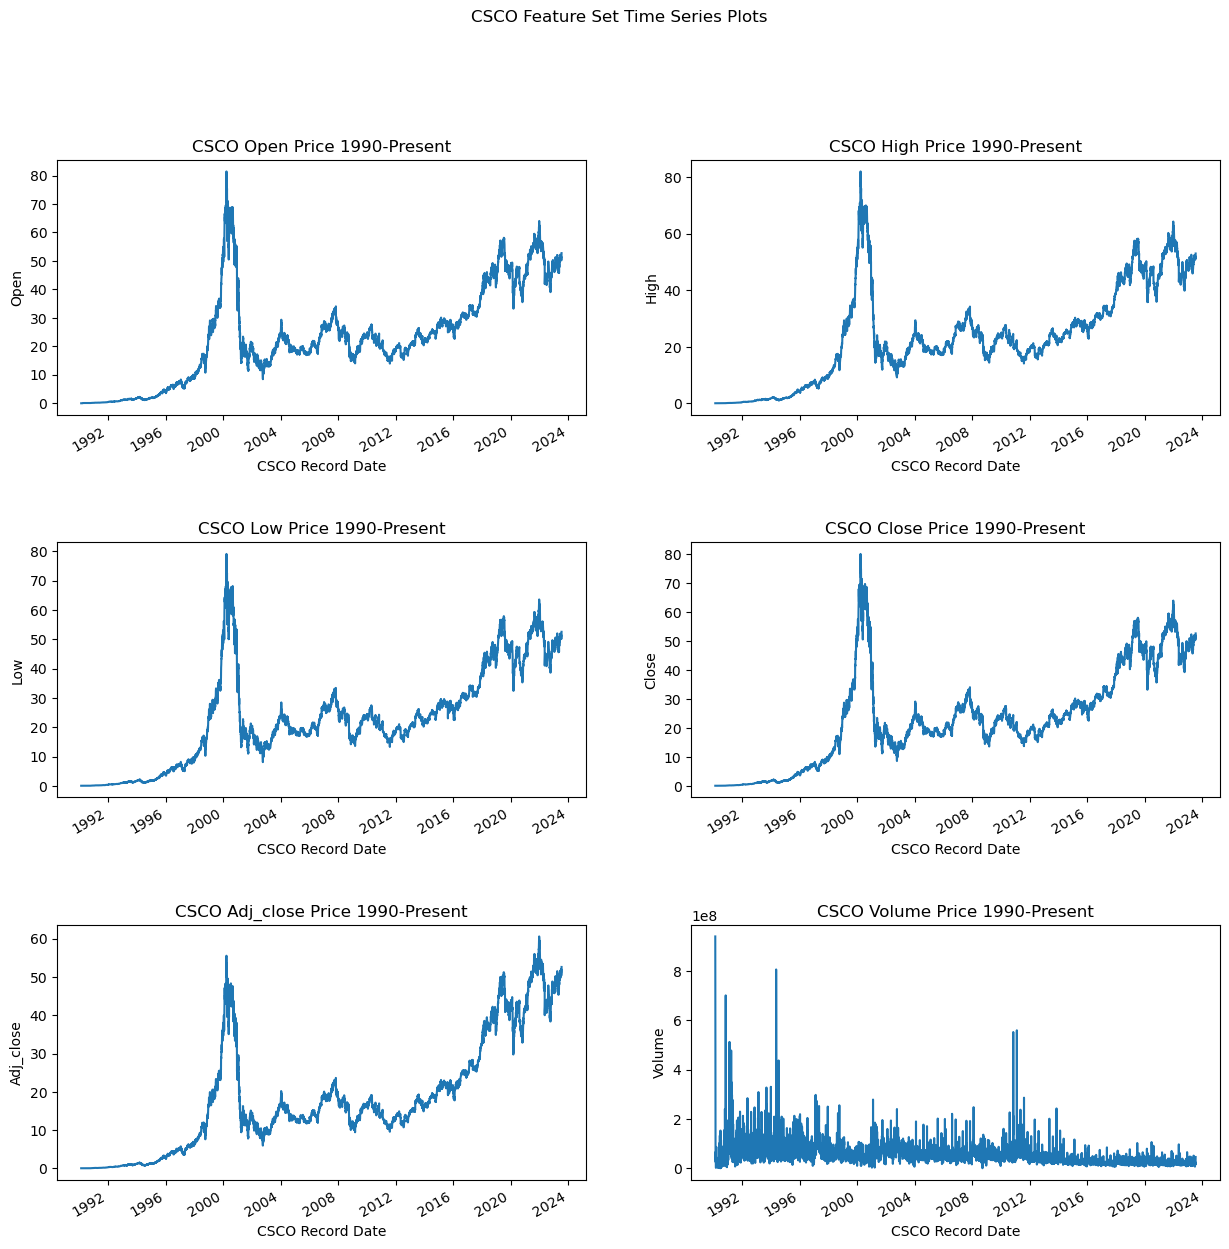

In [58]:
feature_timeseries_plots(df_ts)

### Stationarity